In [2]:
import json
import pandas as pd
import re
from requests import get
from time import sleep
from tqdm import tqdm

In [3]:
pta_name = 'Pta California Congress Of Parents Teachers &amp; Students Inc'
pta_url = f'https://projects.propublica.org/nonprofits/api/v2/search.json?q={pta_name}&state[id]=CA'
extra_ptas = {
    '942783933': 'Parent Advisory Council Japanesethe Bilingual Bicultural Program',
    '943069763': 'Parents Club West Portal School',
    '943344282': 'Argonne Council Of Empowerment'
}

page_num = 0
sf_ptas = []
T = tqdm()
while True:
    R = get( f'{pta_url}&page={page_num}' )
    J = json.loads( R.text )
    if page_num == 0:
        total_pages = int( J['num_pages'] )
        T.reset( total = total_pages )

    T.update( 1 )
    sf_ptas.extend( [ org for org in J['organizations'] if org['city'] == 'San Francisco' ] )

    page_num += 1
    if page_num >= total_pages:
        break

    sleep( 1 )

pd.DataFrame.from_records( sf_ptas ).to_csv( 'sf_ptas.csv', index = False )

100%|██████████| 149/149 [03:18<00:00,  1.37s/it]

In [4]:
pta_df = pd.DataFrame()
ein_baseurl = 'https://projects.propublica.org/nonprofits/api/v2/organizations/'

sf_pta_eins = set(
    [ org['ein'] for org in sf_ptas ]
    + list( extra_ptas.keys() )
)

for ein in tqdm( sf_pta_eins ):
    R = get( f'{ein_baseurl}/{ein}.json' )
    J = json.loads( R.text )

    if 'filings_with_data' not in J:
        continue

    org = J['organization']
    df = pd.concat( 
        [
            pd.DataFrame.from_records( J['filings_with_data' ] ),
            pd.DataFrame.from_records( [ {
                key: value
                for key, value in org.items()
                if key in [ 'tax_period', 'asset_amount', 'income_amount', 'revenue_amount' ] } ] )
        ],
        axis = 0,
        ignore_index = True
    ).assign(
        org_name = org['name'],
        org_subname = org['sub_name'] if 'sub_name' in org else org['sort_name'],
        ein = org['ein']
    )

    pta_df = pd.concat( [ pta_df, df ], axis = 0, ignore_index = True )
    sleep( 1 )

pta_df.to_csv( './sf_pta_taxes.csv', index = False )

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_23297/3413313801.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pta_df = pd.concat( [ pta_df, df ], axis = 0, ignore_index = True )
/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_23297/3413313801.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pta_df = pd.concat( [ pta_df, df ], axis = 0, ignore_index = True )
/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_23297/3413313801.py:33: FutureWarning: The beha

In [5]:
# pta_df[['org_subname','ein','tax_prd_yr','totrevenue','totfuncexpns','tax_period','income_amount','revenue_amount','grsinc170']] \
#     [lambda _df: _df.org_subname.str.contains( 'Rosa' )]


In [6]:
%%script false --no-raise-error

newline = ',\n    '
all_org_names = [ f"'{org_name}': ''" for org_name in pta_df.org_subname.unique() ]
print( f"""
{{
    {newline.join( all_org_names )}
}}
""" )

school_names = pd.read_csv( '../lottery/merged/sfusd-school-names.csv' )
print( '\n'.join( [ f"'{school_name}'" for school_name in school_names.school_name.unique() ] ) )

In [7]:
ein_recodes = {
    'George Washington High School Ptsa': 'Washington (George) HS',
    'San Francisco Public Montessori Pta': 'SF Public Montessori ES',
    'Chinese Immersion School At Deavila': 'Chinese Immersion School at DeAvila ES',
    'Paul Revere Elementary School Pta': 'Revere (Paul) K-8',
    '4447 Junipero Serra Elementary Pta': 'Serra (Junipero) ES',
    'Abraham Lincoln High Ptsa': 'Lincoln (Abraham) HS',
    '337 Ulloa Elementary School Pta': 'Ulloa ES',
    'Parents & Teachers Of B V   H M Pta': 'Buena Vista Horace Mann K-8',
    'Lafayette Elementary Pta': 'Lafayette ES',
    'Claire Lilienthal Elementary Pta': 'Lilienthal (Claire) K-8',
    '4977 Jose Ortega Elementary Pta': 'Ortega (Jose) ES',
    'A P Giannini Middle Pta': 'Giannini (A.P.) MS',
    '4208 Daniel Webster Elementary Pta': 'Webster (Daniel) ES',
    'Visitacion Valley Elementary Pta': 'Visitacion Valley ES',
    'Teca Pta': '', # THOMAS EDISON CHARTER ACADEMY
    'Hillcrest Elementary School Pta': 'Hillcrest ES',
    'Bessie Carmichael School Pta': 'Carmichael (Bessie) K-8',
    'E R Taylor Elementary Pta': 'Taylor (Edward R) ES',
    'Roosevelt Pta': 'Roosevelt MS',
    '338 Raoul Wallenberg Traditional Hi': 'Wallenberg (Raoul) HS',
    'Spring Valley Science School Pta': 'Spring Valley Science ES',
    'Dianne Feinstein Elementry School P': 'Feinstein (Dianne) ES',
    'Ruth Asawa School Of The Arts Ptsa': 'Asawa (Ruth) SOTA HS',
    '5945 Starr King Elementary Pta': 'King (Thomas Starr) ES',
    '5943 William Mckinley Elem Sch Pta': 'McKinley ES',
    '4185 Sutro Elementary Pta': 'Sutro ES',
    'Rooftop Elementary Pta': 'Rooftop K-8',
    'Mlk Pta': 'King Jr (Dr Martin L) MS',
    'Presidio Ees Family Council Pta': 'Presidio EES',
    'Francis Scott Key Elementary Pta': 'Key (Francis Scott) ES',
    'Everett Middle School Ptsa': 'Everett MS',
    'Robert Louis Stevenson Elem Pta': 'Stevenson (Robert Louis) ES',
    'Families Of Sunset Pta': 'Sunset ES',
    '2 Nd San Francisco District Pta': '',
    '328 Presidio Middle School Ptsa': 'Presidio MS',
    'Academy Of Sf Ptsa': 'The Academy - SF @ McAteer HS',
    'Alvarado Elementary Pta': 'Alvarado ES',
    'Guadalupe Elementary Pta': 'Guadalupe ES',
    '5901 Marshall Elementary School Pta': 'Marshall ES',
    'Marina Middle Pta': 'Marina MS',
    'Lakeshore Elementary Pta': 'Lakeshore ES',
    'Sunnyside Elementary Pta': 'Sunnyside ES',
    '306 Leonard Flynn Elementary Pta': 'Flynn (Leonard R) ES',
    'Mission High School Ptsa': 'Mission HS',
    '301 Aptos Middle School Pta': 'Aptos MS',
    '5389 James Lick Middle School Ptsa': 'Lick (James) MS',
    'Font Pta': 'New Traditions ES',
    'Dolores Huerta Elementary Pta': 'Huerta (Dolores) ES',
    'Galileo Academy Of Sci Tech Ptsa': 'Galileo HS',
    '5822 Balboa High School Ptsa': 'Balboa HS',
    'Miraloma Elementary School Pta': 'Miraloma ES',
    '309 Grattan Elementary Pta': 'Grattan ES',
    'Burton High School Ptsa': 'Burton (Phillip and Sala) HS',
    '5974 George Peabody Elementary Pta': 'Peabody (George) ES',
    'Lawton Alternative School Pta': 'Lawton K-8',
    'Clarendon School': 'Clarendon ES',
    '3747 Alamo Elementary Pta': 'Alamo ES',
    'Jefferson Elementary School Pta': 'Jefferson ES',
    'Longfellow Elementary Pta': 'Longfellow ES',
    'Rosa Parks Elementary Pta': 'Parks (Rosa) ES',
    'Monroe Elementary School Pta': 'Monroe ES',
    'Sanchez Elementary Pta': 'Sanchez ES',
    'Lowell High School Ptsa': 'Lowell HS',
    'James Denman Ptsa': 'Denman (James) MS',
    'John Oconnell High School Pta': "O'Connell (John) HS",
    'Mlk Ptsa': '', # LIKELY MLK, but insufficient revenue (ProPublica doesn't have data for 990 postcards); no record in IRS
    'Sherman Pta': 'Sherman ES'
}

for k, v in ein_recodes.items():
    if len( v ):
        continue

    print( k )



# 'Argonne ES'
# 'Access SFUSD: Bay Street'
# 'Access SFUSD: The Arc'
# 'Harte (Bret) ES'
# 'Bryant ES'
# 'Independence HS'
# 'Lee (Edwin and Anita) Newcomer ES'
# 'Cleveland ES'
# 'Yu (Alice Fong) K-8'
# 'Sloat (Commodore) ES'
# 'Lau (Gordon J) ES'
# 'SF Community K-8'
# 'Milk (Harvey) Civil Right ES'
# 'Drew (Dr Charles) College Preparatory Academy ES'
# 'El Dorado ES'
# 'Cobb (Dr William L) ES'
# 'Francisco MS'
# 'McCoppin (Frank) ES'
# 'Garfield ES'
# 'Glen Park ES'
# 'Chavez (Cesar) ES'
# 'Hoover (Herbert) MS'
# 'SF International HS'
# 'Carver (Dr George W) ES'
# 'Parker (Jean) ES'
# 'Muir (John) ES'
# 'Moscone (George R) ES'
# 'Mission Education Center ES'
# 'Jordan (June) HS'
# 'Redding ES'
# 'Wo (Yick) ES'
# 'Sheridan ES'
# 'Malcolm X Academy ES'
# 'Marshall (Thurgood) HS'
# 'Brown Jr. (Willie) MS'
# 'Tenderloin Community ES'
# 'Visitacion Valley MS'
# 'Chin (John Yehall) ES'
# 'West Portal ES'
# 'Argonne EES'
# 'Stockton (Commodore) EES'
# 'Noriega EES'
# 'McLaren (John) EES'
# 'Serra (Junipero) Annex EES'
# 'Rodriguez (Zaida T) EES'
# 'Tule Elk Park EES'

Teca Pta
2 Nd San Francisco District Pta
Mlk Ptsa


In [8]:
sf_ptas = pd.read_csv( './sf_pta_taxes.csv' ) \
    .merge(
        pd.DataFrame.from_records( [ { 'org_subname': key, 'school_name': value } for key, value in ein_recodes.items() ] ),
        on = 'org_subname'
    )

max_grade = 5

# schools = pd.read_csv( '../calpads/merged/sfusd-school-codes.csv' ) \
#     [lambda _df: ( _df.grade_low == 'K' ) & ( _df.grade_high == f'{max_grade}' )] \
#     .assign( school_id = lambda _df: _df.school_code.astype( int ) ) \
#     [['school_id']]
    # .merge( pd.read_csv( '../lottery/merged/sfusd-school-names.csv' )[['school_id','school_name']] )
schools = pd.read_csv( '../lottery/merged/sfusd-school-names.csv' ) \
    [lambda _df: _df.school_name.str.contains( ' ES' )]
schools = schools.merge( sf_ptas, on = 'school_name', how = 'left' )

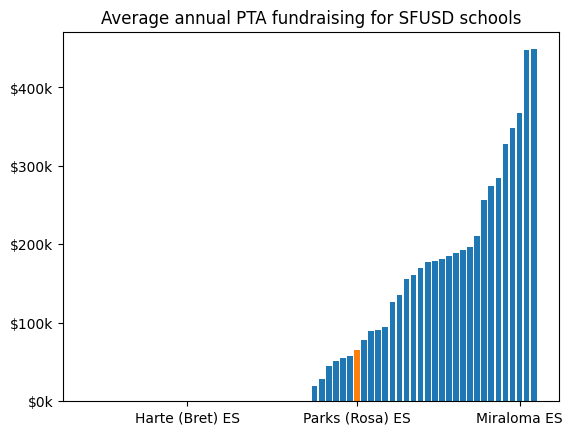

In [9]:
# pd.read_csv( '../lottery/merged/sfusd-school-names.csv' )
rev = schools \
    .assign( revenue = lambda _df: _df.totrevenue.fillna( 0 ) + _df.revenue_amount.fillna( 0 ) ) \
    [['tax_period','school_name','revenue']] \
    [['school_name','revenue']] \
    .groupby( 'school_name' ) \
    .mean() \
    .reset_index()

rev = rev.sort_values( 'revenue' )
import matplotlib.pyplot as plot
from matplotlib.ticker import FuncFormatter

figure, axes = plot.subplots()
axes.bar( rev.school_name, rev.revenue )
axes.yaxis.set_major_formatter( FuncFormatter( lambda x, pos: f'${x/1000:0.0f}k' ) )
axes.set_xticks( [] )

mask = rev.school_name.str.contains( 'arks' )
axes.bar( rev[mask].school_name, rev[mask].revenue )
axes.set_xticks( [ 'Harte (Bret) ES', 'Parks (Rosa) ES', 'Miraloma ES' ] )
axes.set_xticklabels( [ 'Harte (Bret) ES', 'Parks (Rosa) ES', 'Miraloma ES' ], rotation = 0 )
axes.set_title( 'Average annual PTA fundraising for SFUSD schools' )

plot.show()
# schools

In [11]:
sf_ptas[sf_ptas.school_name.str.contains( 'arks' )]

,tax_prd,tax_prd_yr,formtype,pdf_url,updated,totrevenue,totfuncexpns,totassetsend,totliabend,pct_compnsatncurrofcr,...,profndraising,txexmptbndsend,secrdmrtgsend,unsecurednotesend,retainedearnend,totnetassetend,gftgrntsrcvd170,grsrcptsrelated170,grsrcptsadmissn509,school_name
525,202406.0,2024.0,1.0,NaN,2025-08-05T16:13:18.490Z,99504.0,61769.0,118719.0,0.0,-0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parks (Rosa) ES
526,202306.0,2023.0,1.0,https://projects.propublica.org/nonprofits/dow...,2024-08-28T20:25:07.552Z,46645.0,51772.0,80984.0,0.0,-0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parks (Rosa) ES
527,202206.0,2022.0,1.0,NaN,2024-08-28T20:25:07.552Z,58507.0,39855.0,86110.0,0.0,-0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parks (Rosa) ES
528,202106.0,2021.0,1.0,NaN,2022-07-01T20:44:59.760Z,27755.0,45665.0,42309.0,0.0,-0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parks (Rosa) ES
529,202006.0,2020.0,1.0,https://projects.propublica.org/nonprofits/dow...,2022-04-05T21:24:05.446Z,69768.0,77978.0,59894.0,0.0,-0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parks (Rosa) ES
530,201906.0,2019.0,1.0,https://projects.propublica.org/nonprofits/dow...,2022-04-05T21:15:44.551Z,96503.0,81108.0,76880.0,0.0,-0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parks (Rosa) ES
531,201806.0,2018.0,1.0,https://projects.propublica.org/nonprofits/dow...,2022-04-05T21:20:30.969Z,72038.0,57040.0,52222.0,0.0,-0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parks (Rosa) ES
532,201706.0,2017.0,1.0,NaN,2021-09-13T17:59:45.619Z,52271.0,52665.0,37224.0,0.0,-0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parks (Rosa) ES
533,201606.0,2016.0,1.0,https://projects.propublica.org/nonprofits/dow...,2017-06-30T00:41:33.695Z,44700.0,62716.0,37618.0,0.0,-0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parks (Rosa) ES
534,201506.0,2015.0,1.0,https://projects.propublica.org/nonprofits/dow...,2017-06-30T00:41:34.283Z,55961.0,63981.0,55404.0,0.0,-0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parks (Rosa) ES


In [129]:
pta_df[pta_df.org_subname.str.contains( 'arks' )][[
       'pdf_url', 'updated', 'totrevenue', 'totfuncexpns', 'totassetsend',
       'totliabend', 'pct_compnsatncurrofcr', 'subseccd', 'totcntrbs',
       'prgmservrev', 'duesassesmnts', 'othrinvstinc', 'grsamtsalesastothr',
       'basisalesexpnsothr', 'gnsaleofastothr', 'grsincgaming',
       'grsrevnuefndrsng', 'direxpns', 'netincfndrsng', 'grsalesminusret',
       'costgoodsold', 'grsprft', 'othrevnue', 'totrevnue', 'totexpns',
       'totexcessyr', 'othrchgsnetassetfnd', 'totnetassetsend', 'unrelbusincd',
       'initiationfee', 'grspublicrcpts', 'nonpfrea', 'gftgrntrcvd170',
       'txrevnuelevied170', 'srvcsval170', 'grsinc170', 'grsrcptsrelatd170',
       'totgftgrntrcvd509', 'grsrcptsadmiss509', 'txrevnuelevied509',
       'srvcsval509', 'subtotsuppinc509', 'totsupp509', 'tax_pd',
       'unrelbusinccd', 'initiationfees', 'grsrcptspublicuse', 'grsincmembers',
       'grsincother', 'totcntrbgfts', 'totprgmrevnue', 'invstmntinc',
       'txexmptbndsproceeds', 'royaltsinc', 'grsrntsreal', 'grsrntsprsnl',
       'rntlexpnsreal', 'rntlexpnsprsnl', 'rntlincreal', 'rntlincprsnl',
       'netrntlinc', 'grsalesecur', 'grsalesothr', 'cstbasisecur',
       'cstbasisothr', 'gnlsecur', 'gnlsothr', 'netgnls', 'grsincfndrsng',
       'lessdirfndrsng', 'lessdirgaming', 'netincgaming', 'grsalesinvent',
       'lesscstofgoods', 'netincsales', 'miscrevtot11e', 'compnsatncurrofcr',
       'othrsalwages', 'payrolltx', 'profndraising', 'txexmptbndsend',
       'secrdmrtgsend', 'unsecurednotesend', 'retainedearnend',
       'totnetassetend', 'gftgrntsrcvd170', 'grsrcptsrelated170',
       'grsrcptsadmissn509']]

,pdf_url,updated,totrevenue,totfuncexpns,totassetsend,totliabend,pct_compnsatncurrofcr,subseccd,totcntrbs,prgmservrev,...,payrolltx,profndraising,txexmptbndsend,secrdmrtgsend,unsecurednotesend,retainedearnend,totnetassetend,gftgrntsrcvd170,grsrcptsrelated170,grsrcptsadmissn509
483,https://projects.propublica.org/nonprofits/dow...,2024-08-28T20:25:07.552Z,46645.0,51772.0,80984.0,0.0,-0.001,3.0,26576.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484,None,2024-08-28T20:25:07.552Z,58507.0,39855.0,86110.0,0.0,-0.001,3.0,21072.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,None,2022-07-01T20:44:59.760Z,27755.0,45665.0,42309.0,0.0,-0.001,3.0,22854.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,https://projects.propublica.org/nonprofits/dow...,2022-04-05T21:24:05.446Z,69768.0,77978.0,59894.0,0.0,-0.001,3.0,38824.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,https://projects.propublica.org/nonprofits/dow...,2022-04-05T21:15:44.551Z,96503.0,81108.0,76880.0,0.0,-0.001,3.0,40266.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488,https://projects.propublica.org/nonprofits/dow...,2022-04-05T21:20:30.969Z,72038.0,57040.0,52222.0,0.0,-0.001,3.0,32019.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489,None,2021-09-13T17:59:45.619Z,52271.0,52665.0,37224.0,0.0,-0.001,3.0,34756.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490,https://projects.propublica.org/nonprofits/dow...,2017-06-30T00:41:33.695Z,44700.0,62716.0,37618.0,0.0,-0.001,3.0,28711.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,https://projects.propublica.org/nonprofits/dow...,2017-06-30T00:41:34.283Z,55961.0,63981.0,55404.0,0.0,-0.001,3.0,29457.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
492,https://projects.propublica.org/nonprofits/dow...,2017-06-30T00:11:47.059Z,68342.0,56650.0,63424.0,0.0,-0.001,3.0,46650.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
